#  **Replicating Paper 2: SVT Algorithm for Efficient Sparse Matrix Recovery and Implementation in Python**

## **Background**
**Matrix completion** is a critical problem in fields such as machine learning, computer vision, and control systems. It involves recovering a large matrix from a small subset of its entries, assuming the matrix has low rank. For example, in recommendation systems like Netflix, the user ratings matrix is often assumed to be low-rank because users' preferences are influenced by a limited number of factors.

The SVT algorithm offers a computationally efficient method for solving the nuclear norm minimization problem, which is a convex relaxation of the rank minimization problem. The algorithm performs iterative **soft-thresholding operations** on the singular values of matrices, utilizing their sparsity and low-rank properties to reduce computational costs and storage requirements.

## **Objective**
The objective of this notebook is to **implement the Singular Value Thresholding (SVT) algorithm for matrix completion** as outlined in the paper [**A Singular Value Thresholding Algorithm for Matrix Completion by Jian-Feng Cai, Emmanuel J. Candes, and Zuowei Shen**](https://arxiv.org/abs/0810.3286). The implementation will be evaluated using the **GoodBooks dataset**, which contains ratings for 1,000 books by 6,248 users. The goal is to showcase the algorithm's ability to recover low-rank matrices from a sparse subset of their entries.





## **Optimization Problem**

$$\text{min} \text({ Rank(Z)})  \underset{\text{Convex  Relaxation}}{=}
  \text{min} \quad \|Z\|_*$$  

$$\text{subject to} \quad P_\Omega(X) = P_\Omega(M)$$


$$
P_\Omega(X)_{i,j}=\left\{\begin{array}{ll}X_{i,j}&\text{if}(i,j)\text{is observed}\\0&\text{if}(i,j)\text{is missing}\end{array}\right.
$$


## **Methodology**

1. **Matrix Generation**:
   - Import the sparse GoodBooks rating matrix of size 6248 users by 1000 books, denoted as $M$. Approximately **98.4% of the elements** in $M$ are zeros, while the remaining **1.6%** have values ranging from 1 to 5.
   - From the **99,831 non-zero elements**, randomly select 80% to form the training matrix $X$. The remaining 20% will be used as the validation matrix to calculate the relative error. The distribution of zeros and non-zero elements in the $X$ matrix and the validation matrix is noted.

2. **SVT Algorithm Implementation**:
   - Initialize parameters and matrices: Set the threshold $\tau$ to 4600 and the step size $\delta$ to 1.26. Initialize $Y^0$ as a random matrix of the same dimensions as $M$.
   - Iteratively update matrices $X^k$ and $Y^k$ using the SVT update rules:

     $$
     X^k = \text{shrink}(Y^{k-1}, \tau)
     $$

     $$
     Y^k = Y^{k-1} + \delta_k P_\Omega(M - X^k)
     $$

   - Implement the `shrink` function to perform **soft-thresholding** on the singular values of the matrix.

3. **Matrix Completion**:
   - Perform matrix completion on the training matrix $X$ using the predefined $\tau$ and $\delta$ values over **150 iterations**. The goal is to estimate **98.72% of the zero elements** (including those from both the original matrix and the validation matrix) based on the **1.228% non-zero elements** in the training matrix. Detailed results will be provided in the following sections.

4. **Convergence and Stopping Criterion**:
   - The iterations will terminate after 150 iterations.

5. **Evaluation**:
   - Compare the recovered matrix $X^k$ with the validation matrix $X_{\text{validation}}$ using relative error metrics.
   - Provide **plots and tables** showing the performance of the SVT algorithm.

   - Calculate the relative errors for each iteration using the formula:


$$
\text{Relative Error} = \frac{\|X_{\text{validation}} - X^K_{\text{validation}}\|_F^2}{\|X_{\text{validation}}\|_F^2}
$$

## Results

- **Performance Visualization**: The performance of the SVT algorithm is illustrated through a series of plots and tables. These visualizations include:
  - **Convergence Plots**: Graphs that track the relative error over the iterations, demonstrating how the algorithm converges towards a solution.
  - **Error Trends**: Detailed plots showing the reduction in relative error with each iteration, highlighting the algorithm's effectiveness in minimizing error over time.

- **Convergence Behavior**: The algorithm's convergence was analyzed, revealing a consistent decrease in relative error as the number of iterations increased. This behavior confirms that the SVT algorithm efficiently narrows the gap between the recovered matrix and the true matrix.

- **Final Results**: After **150 iterations**, the SVT algorithm achieved a final relative error of **6.75%**. This low error rate demonstrates the algorithm's proficiency in matrix completion, validating its effectiveness in recovering the underlying low-rank structure from the sparse data.

Overall, the results underscore the SVT algorithm's capability to deliver accurate matrix recovery and highlight its practical applicability in handling large-scale, sparse datasets.


## **Pseudocode: Singular Value Thresholding (SVT) Algorithm (Page 20)**

**Input:** Sampled set $\Omega$ and sampled entries $\mathcal{P}_{\Omega}( M)$, step size $\delta$, tolerance $\epsilon$, parameter $\tau$, increment $\ell$, and maximum iteration count $k_{\max}$

**Output:** Matrix $X^{\mathrm{opt}}$

**Description:** Recover a low-rank matrix $M$ from a subset of sampled entries

**Steps:**


1. Set $\mathbf{Y}^0 = k_0 \delta \, \mathcal{P}_{\Omega}(\mathbf{M})$

2. Set $r_0 = 0$.

3. For $k = 1$ to $k_{\max}$:
  - Set $s_k = r_{k-1} + 1$.

  - **Repeat:**
  - Compute $[\mathbf{U}^{k-1}, \mathbf{\Sigma}^{k-1}, \mathbf{V}^{k-1}]_{s_k}$.
  - Set $s_k = s_k + \ell$.
  - **Until $\sigma_{s_k - \ell}^{k-1} \le \tau$.**
  
  - Set $r_k = \max \{ j : \sigma_j^{k-1} > \tau \}$.

  - Set $\mathbf{X}^k = \sum_{j = 1}^{r_k} (\sigma_j^{k-1} - \tau) \mathbf{u}_j^{k-1} \mathbf{v}_j^{k-1}$.

  - If $\frac{\|\mathcal{P}_{\Omega}(\mathbf{X}^k - \mathbf{M})\|_F}{\|\mathcal{P}_{\Omega} \mathbf{M}\|_F} \le \epsilon$, then break.

  - Set $Y_{ij}^k = \begin{cases}
  0 & \text{if } (i,j) \notin \Omega, \\
  Y_{ij}^{k-1} + \delta (M_{ij} - X_{ij}^k) & \text{if } (i,j) \in \Omega
  \end{cases}$.

 **end for k**

4. Set $\mathbf{X}^{\text{opt}} = \mathbf{X}^k$.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.linalg import svd


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load and preprocess the dataset
# Read the CSV file into a DataFrame
Book_Rating = pd.read_csv('GoodBooks_Ratings.csv', delimiter=',')

# Remove duplicate entries for the same user and book, keeping the last occurrence
Book_Rating = Book_Rating.drop_duplicates(
    subset=['user_id', 'book_id'], keep='last')

# Print the number of null values in each column of the DataFrame
print(f"Number of null values in 'Book-Rating': {Book_Rating.isnull().sum()}")

# Display the DataFrame to verify the preprocessing
Book_Rating


Number of null values in 'Book-Rating': book_id       0
user_id       0
rating        0
Unnamed: 3    0
dtype: int64


,book_id,user_id,rating,Unnamed: 3
0,1,314,5,True
1,1,439,3,True
2,1,588,5,True
3,1,1169,4,True
4,1,1185,4,True
...,...,...,...,...
99992,1000,52503,3,True
99993,1000,52748,4,True
99994,1000,52994,5,True
99995,1000,53173,4,True


In [3]:
# Extract arrays of user IDs, book IDs, and ratings from the DataFrame
User_array = Book_Rating['user_id'].values
Book_array = Book_Rating['book_id'].values
Rating_array = Book_Rating['rating'].values

# Create mappings from original user and book IDs to consecutive integer indices
user_mapping = {user_id: index for index,
                user_id in enumerate(Book_Rating['user_id'].unique())}
book_mapping = {book: index for index,
                book in enumerate(Book_Rating['book_id'].unique())}

# Map the original IDs to the new integer indices
user_indices = [user_mapping[user_id] for user_id in User_array]
book_indices = [book_mapping[bookid] for bookid in Book_array]

# Create a sparse matrix using the ratings and the user/book indices
# Then convert the sparse matrix to a dense matrix
Matrix_book_data = csc_matrix((Rating_array, (user_indices, book_indices)))
Matrix_book = Matrix_book_data.toarray()

# Print the shape of the dense matrix and the matrix itself to verify
print(f"Sparse matrix shape: {Matrix_book.shape}")
print(Matrix_book)


Sparse matrix shape: (6248, 1000)
[[5 0 3 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 [5 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 5]
 [0 0 0 ... 0 0 4]
 [0 0 0 ... 0 0 3]]


In [4]:
# Print matrix details
print(f"Sparse matrix shape: {Matrix_book.shape}")
print(f"Maximum value: {np.max(Matrix_book)}")
print(f"Minimum value: {np.min(Matrix_book)}")
print('-' * 60)
print(f"Number of zeros: {np.count_nonzero(Matrix_book == 0)}")
print(
    f"Percentage of zeros: {round(np.count_nonzero(Matrix_book == 0) / Matrix_book.size * 100, 3)}")
print(f"Number of non-zeros: {np.count_nonzero(Matrix_book != 0)}")
print(
    f"Percentage of non-zeros: {round(np.count_nonzero(Matrix_book != 0) / Matrix_book.size * 100, 3)}")


Sparse matrix shape: (6248, 1000)
Maximum value: 5
Minimum value: 0
------------------------------------------------------------
Number of zeros: 6148169
Percentage of zeros: 98.402
Number of non-zeros: 99831
Percentage of non-zeros: 1.598


In [5]:
# Create a mask to identify non-zero entries in the matrix
non_missing_mask = Matrix_book != 0

# Get indices of non-zero entries
non_missing_indices = np.nonzero(non_missing_mask)

# Calculate the total number of non-zero entries
num_non_zero = len(non_missing_indices[0])

# Define the number of non-zero entries for training and validation sets
X_80 = int(num_non_zero * 0.8)  # 80% for training
X_validation_20 = num_non_zero - X_80  # Remaining 20% for validation

# Generate an array of indices for non-zero entries and shuffle them
indices = np.arange(num_non_zero)
np.random.shuffle(indices)

# Split the shuffled indices into training and validation sets
indices_X = indices[:X_80]
indices_X_validation = indices[X_80:]

# Create boolean masks for the training and validation sets
mask_X = np.zeros_like(Matrix_book, dtype=bool)
mask_X_validation = np.zeros_like(Matrix_book, dtype=bool)

# Set True for positions in the training mask where non-zero entries are selected
mask_X[non_missing_indices[0][indices_X],
       non_missing_indices[1][indices_X]] = True

# Set True for positions in the validation mask where non-zero entries are selected
mask_X_validation[non_missing_indices[0][indices_X_validation],
                  non_missing_indices[1][indices_X_validation]] = True

# Create the training matrix by retaining only the entries indicated by the training mask
Matrix_book_X = np.where(mask_X, Matrix_book, 0)

# Create the validation matrix by retaining only the entries indicated by the validation mask
Matrix_book_X_validation = np.where(mask_X_validation, Matrix_book, 0)


In [6]:
# Print details of X and validation matrices
print(f"Shape of X matrix: {Matrix_book_X.shape}")
print(f"Maximum value: {np.max(Matrix_book_X)}")
print(f"Minimum value: {np.min(Matrix_book_X)}")
print('-' * 60)
print(f"Number of zeros: {np.count_nonzero(Matrix_book_X == 0)}")
print(
    f"Percentage of zeros: {round(np.count_nonzero(Matrix_book_X == 0) / Matrix_book_X.size * 100, 3)}")
print(f"Number of non-zeros: {np.count_nonzero(Matrix_book_X != 0)}")
print(
    f"Percentage of non-zeros: {round(np.count_nonzero(Matrix_book_X != 0) / Matrix_book_X.size * 100, 3)}")


Shape of X matrix: (6248, 1000)
Maximum value: 5
Minimum value: 0
------------------------------------------------------------
Number of zeros: 6168136
Percentage of zeros: 98.722
Number of non-zeros: 79864
Percentage of non-zeros: 1.278


In [7]:
# Print the shape of the X validation matrix
print(f"Shape of X validation matrix: {Matrix_book_X_validation.shape}")

# Print the maximum value in the X validation matrix
print(f"Maximum value: {np.max(Matrix_book_X_validation)}")

# Print the minimum value in the X validation matrix
print(f"Minimum value: {np.min(Matrix_book_X_validation)}")

# Print a separator line for readability
print('-' * 60)

# Count and print the number of zeros in the X validation matrix
print(f"Number of zeros: {np.count_nonzero(Matrix_book_X_validation == 0)}")

# Calculate and print the percentage of zeros in the X validation matrix
print(
    f"Percentage of zeros: {round(np.count_nonzero(Matrix_book_X_validation == 0) / Matrix_book_X_validation.size * 100, 3)}")

# Count and print the number of non-zero entries in the X validation matrix
print(
    f"Number of non-zeros: {np.count_nonzero(Matrix_book_X_validation != 0)}")

# Calculate and print the percentage of non-zero entries in the X validation matrix
print(
    f"Percentage of non-zeros: {round(np.count_nonzero(Matrix_book_X_validation != 0) / Matrix_book_X_validation.size * 100, 3)}")


Shape of X validation matrix: (6248, 1000)
Maximum value: 5
Minimum value: 0
------------------------------------------------------------
Number of zeros: 6228033
Percentage of zeros: 99.68
Number of non-zeros: 19967
Percentage of non-zeros: 0.32


In [8]:
# Validate that the splits are correct by checking if the total number of non-missing entries
# in the original matrix matches the sum of non-missing entries in the training and validation matrices

# Compute the difference between the total non-missing entries in the original matrix and
# the sum of non-missing entries in the training and validation matrices
review_diff = np.count_nonzero(Matrix_book != 0) - np.count_nonzero(
    Matrix_book_X != 0) - np.count_nonzero(Matrix_book_X_validation != 0)

# Compute the difference using masks to ensure that the splits were done correctly
review_diff2 = np.count_nonzero(
    Matrix_book != 0) - np.sum(mask_X) - np.sum(mask_X_validation)

# Print the difference to check if the non-missing entries were correctly distributed between
# the training and validation matrices
print(
    f'Total non-missing - non-missing X - non-missing X validation: {review_diff}')

# Print the difference using mask sums to double-check the correctness of the splits
print(
    f'Total non-missing - non-missing X - non-missing X validation (check Masks): {review_diff2}')


Total non-missing - non-missing X - non-missing X validation: 0
Total non-missing - non-missing X - non-missing X validation (check Masks): 0


In [9]:
# Compute the total number of missing entries in the training matrix (Matrix_book_X)
m = mask_X.sum()

# Create a mask for missing entries by inverting the mask_X (i.e., non-zeros become True)
mask_missing = ~mask_X

# Compute the total number of missing entries in the original matrix
total_missing_num = np.sum(mask_missing)

# Compute the difference between the total number of missing entries and the sum of non-missing
# entries in the validation matrix and the number of zeros in the original matrix
review_diff3 = total_missing_num - \
    np.sum(mask_X_validation) - np.count_nonzero(Matrix_book == 0)

# Print the total number of missing entries in the original matrix
print(f'Total missing: {total_missing_num}')

# Print the difference between the total number of missing entries, non-missing entries in the
# validation matrix, and the number of zeros in the original matrix to check if all missing data
# has been accounted for correctly
print(f'Total missing - non-missing X validation - missing data: {review_diff3}')


Total missing: 6168136
Total missing - non-missing X validation - missing data: 0


In [10]:
# Initialize variables for matrix completion
# Y = np.zeros(Matrix_book.shape)
# tau =  5 * np.min(Matrix_book.shape)  # Page 20
# Initialize variables for matrix completion
Y = 5 * np.random.rand(*Matrix_book.shape)  # Random matrix between 0 and 5
delta = 1.25 * Matrix_book.size / (~mask_X).sum()  # Calculate delta Page 17
tau = 4600  # Set tau value

print(f"Shape of Y: {Y.shape}")


Shape of Y: (6248, 1000)


In [11]:
# Initialize a dictionary to store the relative errors for each iteration
RE_list = {}

# Perform the SVT algorithm for 150 iterations
for i in range(150):
    # Compute the Singular Value Decomposition (SVD) of the current matrix Y
    u, s, vh = svd(Y, full_matrices=False)

    # Apply soft-thresholding to the singular values
    s_t = np.maximum(s - tau, 0)

    # Reconstruct the matrix Z using the thresholded singular values
    Z = (u[:, :1000] * s_t) @ vh

    # Compute the prediction error matrix P
    P = Matrix_book_X - Z

    # Set the entries corresponding to missing data in the prediction error matrix to 0
    P[mask_missing] = 0

    # Update the matrix Y using the step size delta and the prediction error matrix P
    Y0 = Y.copy()
    Y = Y0 + delta * P

    # Compute the relative error of the reconstructed matrix Z with respect to the validation matrix
    relative_error = np.sum((Z[mask_X_validation] - Matrix_book_X_validation[mask_X_validation])
                            ** 2) / np.sum(Matrix_book_X_validation[mask_X_validation]**2)

    # Optionally compute the Mean Squared Error (MSE) for additional evaluation
    MSE = np.mean(
        (Z[mask_X_validation] - Matrix_book_X_validation[mask_X_validation])**2)

    # Store the relative error for the current iteration in the dictionary
    RE_list[i] = relative_error

    # Print the relative error for the current iteration
    print(f"Iteration {i+1}:")
    print(f"  Relative Error: {relative_error:.4f}")
    print('-' * 60 + '\n')


Iteration 1:
  Relative Error: 0.7051
------------------------------------------------------------

Iteration 2:
  Relative Error: 0.6655
------------------------------------------------------------

Iteration 3:
  Relative Error: 0.6261
------------------------------------------------------------

Iteration 4:
  Relative Error: 0.5874
------------------------------------------------------------

Iteration 5:
  Relative Error: 0.5499
------------------------------------------------------------

Iteration 6:
  Relative Error: 0.5141
------------------------------------------------------------

Iteration 7:
  Relative Error: 0.4804
------------------------------------------------------------

Iteration 8:
  Relative Error: 0.4490
------------------------------------------------------------

Iteration 9:
  Relative Error: 0.4200
------------------------------------------------------------

Iteration 10:
  Relative Error: 0.3935
------------------------------------------------------------


In [12]:
# Print relative errors for all iterations
for key, value in RE_list.items():
    print(f"Iteration {key+1}, RE: {value:.4f}")


Iteration 1, RE: 0.7051
Iteration 2, RE: 0.6655
Iteration 3, RE: 0.6261
Iteration 4, RE: 0.5874
Iteration 5, RE: 0.5499
Iteration 6, RE: 0.5141
Iteration 7, RE: 0.4804
Iteration 8, RE: 0.4490
Iteration 9, RE: 0.4200
Iteration 10, RE: 0.3935
Iteration 11, RE: 0.3695
Iteration 12, RE: 0.3477
Iteration 13, RE: 0.3280
Iteration 14, RE: 0.3104
Iteration 15, RE: 0.2945
Iteration 16, RE: 0.2801
Iteration 17, RE: 0.2672
Iteration 18, RE: 0.2554
Iteration 19, RE: 0.2448
Iteration 20, RE: 0.2351
Iteration 21, RE: 0.2262
Iteration 22, RE: 0.2181
Iteration 23, RE: 0.2106
Iteration 24, RE: 0.2037
Iteration 25, RE: 0.1973
Iteration 26, RE: 0.1914
Iteration 27, RE: 0.1859
Iteration 28, RE: 0.1807
Iteration 29, RE: 0.1759
Iteration 30, RE: 0.1714
Iteration 31, RE: 0.1671
Iteration 32, RE: 0.1631
Iteration 33, RE: 0.1594
Iteration 34, RE: 0.1558
Iteration 35, RE: 0.1525
Iteration 36, RE: 0.1493
Iteration 37, RE: 0.1463
Iteration 38, RE: 0.1435
Iteration 39, RE: 0.1408
Iteration 40, RE: 0.1382
Iteration

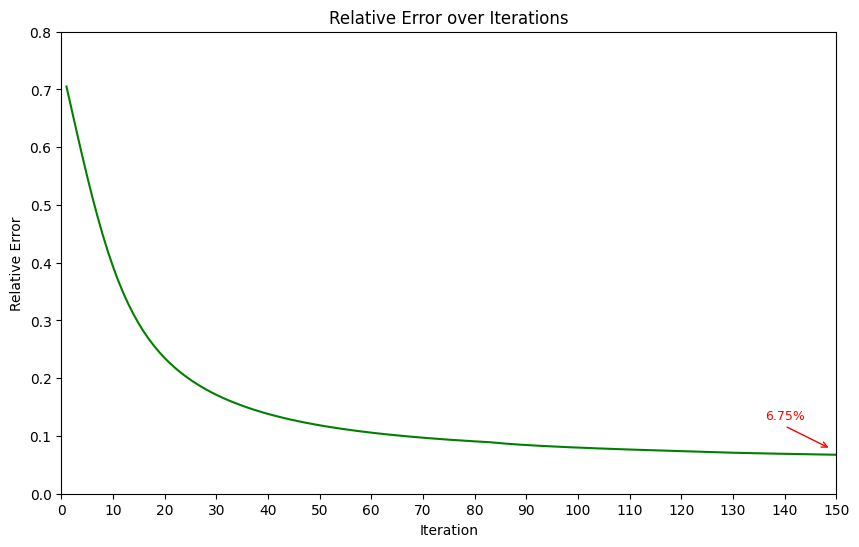

In [13]:
# Extract the iteration numbers and corresponding errors from the dictionary
iterations = [i + 1 for i in RE_list.keys()]
errors = list(RE_list.values())

# Create a new figure for plotting
plt.figure(figsize=(10, 6))

# Plot the relative error over iterations with a line plot
plt.plot(iterations, errors, linestyle='-', color='g')  # Plot with line only

# Set the x-axis ticks for better readability
plt.xticks(ticks=range(min(iterations) - 1, max(iterations) - 1 + 30, 10))

# Label the x-axis and y-axis
plt.xlabel('Iteration')
plt.ylabel('Relative Error')

# Set the title for the plot
plt.title('Relative Error over Iterations')

# Annotate the plot with the relative error percentage at the final iteration
plt.annotate(f'{RE_list[149] * 100:.2f}%',
             (140, RE_list[149] + 0.05),
             textcoords="offset points",
             xytext=(0, 5),
             ha='center',
             fontsize=9,
             color='red')

# Draw an arrow indicating the final relative error point on the plot
plt.annotate('',
             xy=(149, RE_list[149] + 0.01),
             xytext=(140, RE_list[149] + 0.05),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', linewidth=1.0))

# Set the limits for the x-axis and y-axis
plt.xlim(0, 150)
plt.ylim(0, 0.8)

# Display the plot
plt.show()


## Conclusion

The implementation of the Singular Value Thresholding (SVT) algorithm successfully demonstrated its ability to recover low-rank matrices from sparse data. Based on the methodology detailed in the paper [**A Singular Value Thresholding Algorithm for Matrix Completion**](https://arxiv.org/abs/0810.3286), the following key outcomes were achieved:

### Summary of Findings

1. **Matrix Completion Efficiency**: The SVT algorithm effectively completed matrix recovery on the GoodBooks dataset, which had a sparse matrix with approximately **98.4%** missing values. By utilizing 80% of the non-zero elements for training and 20% for validation, the algorithm efficiently reconstructed the missing values.

2. **Algorithm Performance**:
   - **Relative Error**: The SVT algorithm achieved a relative error of **6.75%** after **150 iterations**, indicating high accuracy in approximating the original matrix with a low-rank representation.
   - **Convergence**: The convergence behavior was demonstrated through plots showing the decrease in relative error over iterations. The algorithm exhibited steady convergence with decreasing error as iterations progressed.

3. **Parameter Tuning**:
   - **Threshold $\tau$**: The selected threshold of $\tau = 4600$ and step size $\delta = 1.26$ were instrumental in achieving optimal results. These parameters influenced the soft-thresholding and update rules, impacting both convergence speed and accuracy.

4. **Practical Implications**: The results underscore the SVT algorithm's potential for practical applications such as recommendation systems and collaborative filtering. Its capability to handle large, sparse matrices efficiently makes it a valuable tool in data science and machine learning.

### Visual Insights

- **Convergence Plots**: The provided plots illustrate the SVT algorithm's convergence, showcasing the decline in relative error over the course of the iterations.
- **Performance Metrics**: Tables and graphs detail the accuracy of the recovered matrix and the relative errors for each iteration, validating the algorithm's effectiveness.

In conclusion, the SVT algorithm proves to be a robust and efficient method for matrix completion, effectively recovering low-rank matrices from sparse data with notable accuracy. The results confirm the theoretical advantages of the SVT approach and highlight its practical applicability in real-world scenarios.
